In [1]:
import sys
sys.path.append("../") # go to parent dir

In [2]:
import pandas as pd
import seaborn as sn
import re

from mimic3models.metrics import print_metrics_regression

In [3]:
period_bins = [5, 12, 24, 36, 48, 60, 72]

# [4 weeks, 2 weeks, 1 week, 3 days, 2.5 days, 2 days, 1.5 days, 1 day, .5 days]
remain_bins = [672, 336, 168, 72, 60, 48, 36, 24, 12]

In [4]:
df = pd.read_csv("/mnt/data01/models/lstm/regression/test_predictions/k_lstm.n64.d0.3.dep1.bs256.ts1.0.partition=none.chunk08.test1.2235.state.csv")
# df = pd.read_csv("/mnt/data01/models/linear_regression/logistic/cf_predictions/all.all.l2.C1e-05.csv")  # logistic regression
# df = pd.read_csv("/mnt/data01/models/linear_regression/regression/predictions/all.all.csv")
df.describe(include="all")

,stay,period_length,prediction,y_true
count,525912,525912.000000,525912.000000,525912.000000
unique,6265,NaN,NaN,NaN
top,12805_episode1_timeseries.csv,NaN,NaN,NaN
freq,1988,NaN,NaN,NaN
mean,NaN,143.687375,168.748651,139.145741
std,NaN,202.474764,3722.577389,202.464813
min,NaN,5.000000,-9590.204102,0.000000
25%,NaN,27.000000,54.706963,22.282400
50%,NaN,65.000000,116.207977,60.782000
75%,NaN,173.000000,198.458050,168.562400


In [5]:
# Add patient to the table
df["PATIENT_ID"] = df["stay"].apply(lambda x: int(re.findall(r'[0-9]+_', x)[0][:-1]))
df["EPISODE_ID"] = df["stay"].apply(lambda x: int(re.findall(r'episode[0-9]+_', x)[-1][7:-1]))


In [6]:
# filter patients in the bottom and top 3%
stay_df = df.groupby(df.stay, as_index=False)["period_length"].agg("max")
print(stay_df.describe())

       period_length
count    6265.000000
mean       87.970790
std       127.748688
min         5.000000
25%        28.000000
50%        49.000000
75%        91.000000
max      1992.000000


[Text(0.5, 0, 'LOS (Hours)')]

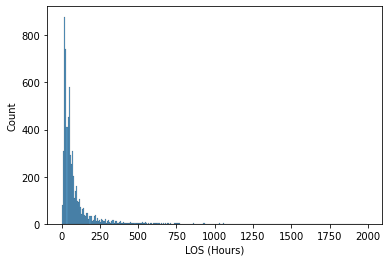

In [7]:
fig = sn.histplot(data=stay_df, x="period_length") #, stat="probability")
fig.set(xlabel='LOS (Hours)')

In [8]:
# Filter quantiles (Windsorization = 94%)
stay_df = stay_df[(stay_df.period_length > stay_df.period_length.quantile(.03)) & \
                  (stay_df.period_length < stay_df.period_length.quantile(.97))]
print(stay_df.describe())
df = df.merge(stay_df[["stay"]], how="inner", left_on="stay", right_on="stay")


       period_length
count    5839.000000
mean       72.739168
std        67.182868
min        17.000000
25%        29.000000
50%        49.000000
75%        86.000000
max       396.000000


[Text(0.5, 0, 'LOS (Hours)')]

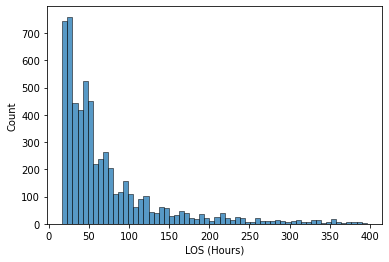

In [9]:
fig = sn.histplot(data=stay_df, x="period_length") #, stat="probability")
fig.set(xlabel='LOS (Hours)')

In [10]:
# Filter only those patiencts that have stay longer than ~ 1 std dev = 60
stay_df = stay_df[stay_df.period_length >= 60]
print(stay_df.describe())
df = df.merge(stay_df[["stay"]], how="inner", left_on="stay", right_on="stay")


       period_length
count    2334.000000
mean      129.656812
std        75.397680
min        60.000000
25%        74.000000
50%       100.000000
75%       157.750000
max       396.000000


[Text(0.5, 0, 'LOS (Hours)')]

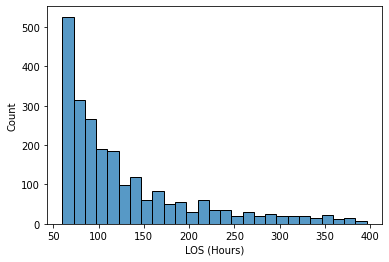

In [11]:
fig = sn.histplot(data=stay_df, x="period_length") #, stat="probability")
fig.set(xlabel='LOS (Hours)')

In [24]:
# Slice the data by period snapshots and test at each interval
df_list = []

period_df = df[df.period_length <= period_bins[0]].copy()
period_df["period_bin"] = period_bins[0]
df_list.append(period_df)

for bin in period_bins[1:]:
    period_df = df[df.period_length == bin].copy()
    period_df["period_bin"] = bin
    df_list.append(period_df)

period_df = pd.concat(df_list)
print(f"Period bins (hours): {period_bins}")
period_df.head(3)

Period bins (hours): [5, 12, 24, 36, 48, 60, 72]


,stay,period_length,prediction,y_true,PATIENT_ID,EPISODE_ID,period_bin
0,10011_episode1_timeseries.csv,5.0,30.204926,327.4168,10011,1,5
328,10042_episode1_timeseries.csv,5.0,23.271866,190.3960,10042,1,5
519,10094_episode1_timeseries.csv,5.0,135.047562,93.4336,10094,1,5


In [13]:
period_group_df = period_df.groupby("period_bin", as_index=False)["stay"].count()
period_group_df.head(10)

,period_bin,stay
0,5,2322
1,12,2331
2,24,2334
3,36,2334
4,48,2334
5,60,2334
6,72,1853


[Text(0.5, 0, 'With LOS greater than (Hours)'), Text(0, 0.5, 'Count')]

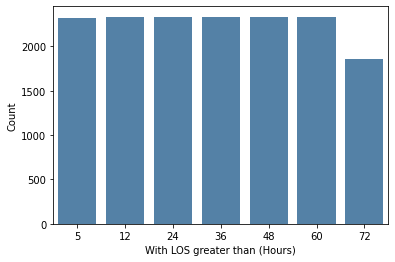

In [14]:
# All our samples have length of stay greater than 60 and most greater than 72
fig = sn.barplot(data=period_group_df, x="period_bin", y="stay", color="steelblue")
fig.set(xlabel='With LOS greater than (Hours)', ylabel='Count')


In [15]:
for bin in period_bins:
    metric_df = period_df[period_df.period_bin == bin].copy()
    print(f"\nMetrics at {bin} hours")
    print(f'Unique episodes: {len(metric_df.stay.unique())}')
    print(f'Unique patients: {len(metric_df.PATIENT_ID.unique())}')
    print_metrics_regression(metric_df["y_true"], metric_df["prediction"], custom_bin=2, fill_ones=True)


Metrics at 5 hours
Unique episodes: 2322
Unique patients: 2037
Custom bins confusion matrix:
[(-1e+18, 0.5), (0.5, 1), (1, 1.5), (1.5, 2), (2, 2.5), (2.5, 3), (3, 7), (7, 14), (14, 1e+18)]
[[  1   0   0   0   0   0   0   0   0]
 [  0   1   0   0   0   0   0   0   0]
 [  0   0   1   0   0   0   0   0   0]
 [  0   0   0   1   0   0   0   0   0]
 [  3   4  18  14  15  17  79  12   0]
 [ 23  25  37  44  47  45 225  49   0]
 [ 29  43  61  72 113  97 594 173   1]
 [  5   6  18  15  24  28 252  80   0]
 [  1   0   1   0   4   2  30  20   1]]
Mean absolute deviation (MAD) = 65.58341033204134
Mean squared error (MSE) = 7498.415296004909
Mean absolute percentage error (MAPE) = 55.4821680086209
Cohen kappa score = 0.07050969330734735

Metrics at 12 hours
Unique episodes: 2331
Unique patients: 2043
Custom bins confusion matrix:
[(-1e+18, 0.5), (0.5, 1), (1, 1.5), (1.5, 2), (2, 2.5), (2.5, 3), (3, 7), (7, 14), (14, 1e+18)]
[[  1   0   0   0   0   0   0   0   0]
 [  0   1   0   0   0   0   0   0   

In [26]:
# Slice for Remaining bin statistics
df_list = []

for bin in remain_bins:
    remain_df = df[(df.y_true >= bin - 1) & (df.y_true < bin)].copy()
    remain_df["remain_bin"] = bin
    df_list.append(remain_df)

remain_df = pd.concat(df_list)
print(f"Remaining bins (hours): {remain_bins}")
remain_df.head(3)

Remaining bins (hours): [672, 336, 168, 72, 60, 48, 36, 24, 12]


,stay,period_length,prediction,y_true,PATIENT_ID,EPISODE_ID,remain_bin
18380,12903_episode1_timeseries.csv,47.0,276.402954,335.6368,12903,1,336
20109,13345_episode1_timeseries.csv,49.0,208.451263,335.8088,13345,1,336
20575,1338_episode1_timeseries.csv,30.0,160.014435,335.7816,1338,1,336


In [17]:
remain_group_df = remain_df.groupby("remain_bin", as_index=False)["stay"].count()
remain_group_df.head(10)

,remain_bin,stay
0,12,2334
1,24,2334
2,36,2334
3,48,2334
4,60,2209
5,72,1704
6,168,493
7,336,60


[Text(0.5, 0, 'LOS Remaining (Hours)'), Text(0, 0.5, 'Count')]

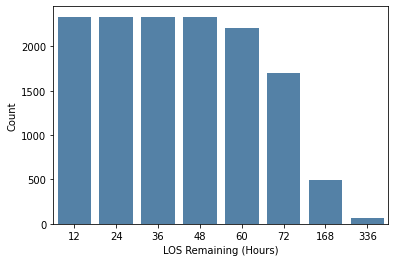

In [27]:
fig = sn.barplot(data=remain_group_df, x="remain_bin", y="stay", color="steelblue")
fig.set(xlabel='LOS Remaining (Hours)', ylabel='Count')

In [20]:
print(f'Unique episodes: {len(remain_df.stay.unique())}')
print(f'Unique patients: {len(remain_df.PATIENT_ID.unique())}')

print_metrics_regression(remain_df["y_true"], remain_df["prediction"], extra=True, custom_bin=2, fill_ones=True)

Unique episodes: 2334
Unique patients: 2046
Custom bins confusion matrix:
[(-1e+18, 0.5), (0.5, 1), (1, 1.5), (1.5, 2), (2, 2.5), (2.5, 3), (3, 7), (7, 14), (14, 1e+18)]
[[149  88 152 196 216 191 994 328  21]
 [128 108 153 174 213 211 965 363  20]
 [138  93 147 166 183 184 983 424  17]
 [136  93 123 210 190 187 920 455  21]
 [104  84 136 145 182 187 855 503  14]
 [ 79  55  74 100 132 116 656 476  17]
 [  9  10  11   8  16  15 190 225  10]
 [  0   0   1   0   1   0  28  31   0]
 [  0   0   0   0   0   0   0   0   1]]
Mean absolute deviation (MAD) = 82.17562962338792
Mean squared error (MSE) = 161537.35993634793
Mean absolute percentage error (MAPE) = 312.180428921863
Cohen kappa score = 0.03244745189855003
F1(micro) = 0.08210846426761277
F1(macro) = 0.07604021727240769
AUC = nan
Recall = 0.08210846426761277
Accuracy = 0.08210846426761277


{'mad': 82.17562962338792,
 'mse': 161537.35993634793,
 'mape': 312.180428921863,
 'kappa': 0.03244745189855003,
 'f1_micro': 0.08210846426761277,
 'f1_macro': 0.07604021727240769,
 'auc': nan,
 'recall': 0.08210846426761277,
 'accuracy': 0.08210846426761277}

In [21]:
for bin in remain_bins:
    metric_df = remain_df[remain_df.remain_bin == bin].copy()
    if len(metric_df) == 0:
        continue

    print(f"\nMetrics where {bin} hours remaining")
    print(f'Unique episodes: {len(metric_df.stay.unique())}')
    print(f'Unique patients: {len(metric_df.PATIENT_ID.unique())}')
    print(f'Predictions: {len(metric_df)}')
    print_metrics_regression(metric_df["y_true"], metric_df["prediction"], extra=True, custom_bin=2, fill_ones=True)


Metrics where 336 hours remaining
Unique episodes: 60
Unique patients: 59
Predictions: 60
Custom bins confusion matrix:
[(-1e+18, 0.5), (0.5, 1), (1, 1.5), (1.5, 2), (2, 2.5), (2.5, 3), (3, 7), (7, 14), (14, 1e+18)]
[[ 1  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  1  0  1  0 28 31  0]
 [ 0  0  0  0  0  0  0  0  1]]
Mean absolute deviation (MAD) = 171.65593443333333
Mean squared error (MSE) = 32609.61283818732
Mean absolute percentage error (MAPE) = 51.1471147707965
Cohen kappa score = 0.5661893119105833
F1(micro) = 0.5652173913043478
F1(macro) = 0.7859903381642511
AUC = nan
Recall = 0.5652173913043478
Accuracy = 0.5652173913043478

Metrics where 168 hours remaining
Unique episodes: 493
Unique patients: 452
Predictions: 493
Custom bins confusion matrix:
[(-1e+18, 0.5), (0.5, 1), (1, 1.5), (1.5, 2), (2, 2.5), (2.5, 3), 